## QA over unstructured data

Using Match LSTM, Pointer Networks, as mentioned in paper https://arxiv.org/pdf/1608.07905.pdf

We start with the pre-processing provided by https://github.com/MurtyShikhar/Question-Answering to clean up the data and make neat para, ques files.


### @TODOs:

1. [done] _Figure out how to put in real, pre-trained embeddings in embeddings layer._
2. [done] _Explicitly provide batch size when instantiating model_
3. [done] is ./val.ids.* validation set or test set?: **validation**
4. [done:em] emInstead of test loss, calculate test acc metrics
    1. todo: new metrics like P, R, F1
5. [done] Update unit test codes

In [1]:
from __future__ import unicode_literals, print_function, division
import matplotlib.pyplot as plt
from io import open
import numpy as np
import unicodedata
import traceback
import string
import random
import time
import re
import os


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

# from networks import Encoder, MatchLSTMEncoder, PointerDecoder

device = torch.device("cuda")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#### Debug Legend

- 5: Print everything that goes in every tensor.
- 4: ??
- 3: Check every model individually
- 2: Print things in training loops
- 1: ??

In [2]:
# Macros 
DATA_LOC = './data/domain/'
MODEL_LOC = './models/mlstms/domain/'
DEBUG = 1

# nn Macros
QUES_LEN, PARA_LEN =  30, 200
VOCAB_SIZE = 120000
# VOCAB_SIZE = glove_file.shape[1]               # @TODO: get actual size
HIDDEN_DIM = 150
EMBEDDING_DIM = 300
BATCH_SIZE = 50                  # Might have total 100 batches.
EPOCHS = 300
TEST_EVERY_ = 1
LR = 0.001
CROP = None

### Encoder 
Use a simple lstm class to have encoder for question and paragraph. 
The output of these will be used in the match lstm

$H^p = LSTM(P)$ 


$H^q = LSTM(Q)$

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, inputlen, macros, glove_file, device):
        super(Encoder, self).__init__()
        
        # Catch dim
        self.inputlen = inputlen
        self.hiddendim = macros['hidden_dim']
        self.embeddingdim =  macros['embedding_dim']
        self.vocablen = macros['vocab_size']
#         self.device = macros['device']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']
        
        # Embedding Layer
#         self.embedding = nn.Embedding(self.vocablen, self.embeddingdim)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(glove_file))
        self.embedding.weight.requires_grad = True
       
        # LSTM Layer
        self.lstm = nn.LSTM(self.embeddingdim, self.hiddendim, bidirectional=True, batch_first=False)
        
    def init_hidden(self, batch_size, device):
        
        # Returns a new hidden layer var for LSTM
        return (torch.zeros((2, batch_size, self.hiddendim), device=device), 
                torch.zeros((2, batch_size, self.hiddendim), device=device))
    
    def forward(self, x, h, device):
        
        # Input: x (batch, len ) (current input)
        # Hidden: h (1, batch, hiddendim) (last hidden state)
        
        # Batchsize: b int (inferred)
        b = x.shape[0]
        
        if self.debug > 4: print("x:\t", x.shape)
        if self.debug > 4: print("h:\t", h[0].shape, h[1].shape)
        
        x_emb = self.embedding(x)
        if self.debug > 4: 
            print("x_emb:\t", x_emb.shape)
#             print("x_emb_wrong:\t", x_emb.transpose(1,0).shape)           
            
        ycap, h = self.lstm(x_emb.transpose(1,0), h)
        if self.debug > 4: 
            print("ycap:\t", ycap.shape)
        
        return ycap, h
    
    
# # with torch.no_grad():
# #     print ("Trying out question encoder LSTM")
# #     model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE)
# #     dummy_x = torch.tensor([22,45,12], dtype=torch.long)
# #     hidden = model.init_hidden()
# #     ycap, h = model(dummy_x, hidden)
    
# #     print(ycap.shape)
# #     print(h[0].shape, h[1].shape)


if DEBUG > 4:
    with torch.no_grad():
        
        macros = {
        "ques_len": QUES_LEN,
        "hidden_dim": HIDDEN_DIM, 
        "vocab_size": VOCAB_SIZE, 
        "batch_size": BATCH_SIZE,
        "para_len": PARA_LEN,
        "embedding_dim": EMBEDDING_DIM,
        "lr": LR,
        "debug":5,
        "device":device
    }

        dummy_para = torch.randint(0,VOCAB_SIZE-1,(PARA_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,PARA_LEN).long()
    #     print (dummy_para.shape)
        dummy_question = torch.randint(0,VOCAB_SIZE-1,(QUES_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,QUES_LEN).long()
    #     print (dummy_question.shape)
        glove_file = torch.randn((VOCAB_SIZE, EMBEDDING_DIM))

    #     print("LSTM with batches")
        ques_model = Encoder(QUES_LEN, macros, glove_file, device).cuda(device)
        para_model = Encoder(QUES_LEN, macros, glove_file, device).cuda(device)
        ques_hidden = ques_model.init_hidden(BATCH_SIZE, device)
        para_hidden = para_model.init_hidden(BATCH_SIZE, device)
        ques_embedded,hidden_ques = ques_model(dummy_question,ques_hidden, device)
        para_embedded,hidden_para = para_model(dummy_para,para_hidden, device)
        
#         print (ques_embedded.shape) # question_length,batch,embedding_dim
#         print (para_embedded.shape) # para_length,batch,embedding_dim
#         print (hidden_para[0].shape,hidden_para[1].shape)

### Match LSTM

Use a match LSTM to compute a **summarized sequential vector** for the paragraph w.r.t the question.

Consider the summarized vector ($H^r$) as the output of a new decoder, where the inputs are $H^p, H^q$ computed above. 

1. Attend the para word $i$ with the entire question ($H^q$)
  
    1. $\vec{G}_i = tanh(W^qH^q + repeat(W^ph^p_i + W^r\vec{h^r_{i-1} + b^p}))$
    
    2. *Computing it*: Here, $\vec{G}_i$ is equivalent to `energy`, computed differently.
    
    3. Use a linear layer to compute the content within the $repeat$ fn.
    
    4. Add with another linear (without bias) with $H_q$
    
    5. $tanh$ the bloody thing
  
  
2. Softmax over it to get $\alpha$ weights.

    1. $\vec{\alpha_i} = softmax(w^t\vec{G}_i + repeat(b))$
    
3. Use the attention weight vector $\vec{\alpha_i}$ to obtain a weighted version of the question and concat it with the current token of the passage to form a vector $\vec{z_i}$

4. Use $\vec{z_i}$ to compute the desired $h^r_i$:

    1. $ h^r_i = LSTM(\vec{z_i}, h^r_{i-1}) $
    


In [4]:
class MatchLSTMEncoder(nn.Module):
    
    def __init__(self, macros, device):
        
        super(MatchLSTMEncoder, self).__init__()
        
        self.hidden_dim = macros['hidden_dim']
        self.ques_len = macros['ques_len']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']    
        
        # Catch lens and params
        self.lin_g_repeat_a_dense = nn.Linear(2*self.hidden_dim, self.hidden_dim)
        self.lin_g_repeat_b_dense = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.lin_g_nobias = nn.Linear(2*self.hidden_dim, self.hidden_dim, bias=False)
        
        self.alpha_i_w = nn.Parameter(torch.rand((self.hidden_dim, 1)))
        self.alpha_i_b = nn.Parameter(torch.rand((1)))
        
        self.lstm_summary = nn.LSTM((self.ques_len+1)*2*self.hidden_dim, self.hidden_dim, batch_first=False)
                                      
    
    def forward(self, H_p, h_ri, H_q, hidden, device):
        """
            Ideally, we would have manually unrolled the lstm 
            but due to memory constraints, we do it in the module.
        """
        
        # Find the batchsize
        batch_size = H_p.shape[1]
        
        H_r = torch.empty((0, batch_size, self.hidden_dim), device=device, dtype=torch.float)
        H_r = torch.cat((H_r, h_ri), dim=0)
        
        if self.debug > 4:
            print( "H_p:\t\t\t", H_p.shape)
            print( "H_q:\t\t\t", H_q.shape)
            print( "h_ri:\t\t\t", h_ri.shape)
            print( "H_r:\t\t\t", H_r.shape)
            print( "hid:\t\t\t", hidden.shape)
        
        for i in range(H_p.shape[0]):
            
            # We call the (W^P.H^P + W^rh^r_i-1 + b^P) as lin_repeat_input.
            
            # We first write out its two components as
            lin_repeat_input_a = self.lin_g_repeat_a_dense(H_p[i].view(1, batch_size, -1))
            if self.debug > 4: print("lin_repeat_input_a:\t", lin_repeat_input_a.shape)
            
            lin_repeat_input_b = self.lin_g_repeat_b_dense(H_r[i].view(1, batch_size, -1))
            if self.debug > 4: print("lin_repeat_input_b:\t", lin_repeat_input_b.shape)
            
            # Add the two terms up
            lin_repeat_input_a.add_(lin_repeat_input_b)
#             if self.debug > 4: print("lin_g_input_b unrepeated:", lin_g_input_b.shape)

            lin_g_input_b = lin_repeat_input_a.repeat(H_q.shape[0], 1, 1)
            if self.debug > 4: print("lin_g_input_b:\t\t", lin_g_input_b.shape)

            # lin_g_input_a = self.lin_g_nobias.matmul(H_q.view(-1, self.ques_len, self.hidden_dim)) #self.lin_g_nobias(H_q)
            lin_g_input_a =  self.lin_g_nobias(H_q)
            if self.debug > 4: print("lin_g_input_a:\t\t", lin_g_input_a.shape)

            G_i = F.tanh(lin_g_input_a + lin_g_input_b)
            if self.debug > 4: print("G_i:\t\t\t", G_i.shape)
            # Note; G_i should be a 1D vector over ques_len
            
            # Attention weights
            alpha_i_input_a = G_i.transpose(1,0).matmul(self.alpha_i_w).view(batch_size, 1, -1)
            if self.debug > 4: print("alpha_i_input_a:\t", alpha_i_input_a.shape)

            alpha_i_input = alpha_i_input_a.add_(self.alpha_i_b.view(-1,1,1).repeat(1,1,self.ques_len))
            if self.debug > 4: print("alpha_i_input:\t\t", alpha_i_input.shape)

            # Softmax over alpha inputs
            alpha_i = F.softmax(alpha_i_input, dim=-1)
            if self.debug > 4: print("alpha_i:\t\t", alpha_i.shape)  
                
            # Weighted summary of question with alpha    
            z_i_input_b = (
                            H_q.transpose(1, 0) *
                           (alpha_i.view(batch_size, self.ques_len, -1).repeat(1, 1, 2*self.hidden_dim))
                          ).transpose(1, 0)
            if self.debug > 4: print("z_i_input_b:\t\t", z_i_input_b.shape)

            z_i = torch.cat((H_p[i].view(1, batch_size, -1), z_i_input_b), dim=0)
            if self.debug > 4: print("z_i:\t\t\t", z_i.shape)

            # Take input from LSTM, concat in H_r and nullify the temp var.                
            h_ri, (_, hidden) = self.lstm_summary(z_i.transpose(1,0).contiguous().view(1, batch_size, -1), 
                                             (H_r[i].view(1,batch_size, -1), hidden))
            if self.debug > 4:
                print("newh_ri:\t\t", h_ri.shape)
                print("newhidden:\t\t", hidden.shape)
            H_r = torch.cat((H_r, h_ri), dim=0)
            
            if self.debug > 4:
                print("\tH_r:\t\t\t", H_r.shape)

        return H_r[1:]
    
    def init_hidden(self, batch_size, device):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros((1, batch_size, self.hidden_dim), device=device)
#                 torch.zeros((1, batch_size, self.hidden_dim), device=device))



if DEBUG > 4:
    with torch.no_grad():
        
        macros = {
            "ques_len": QUES_LEN,
            "hidden_dim": HIDDEN_DIM, 
            "vocab_size": VOCAB_SIZE, 
            "batch_size": BATCH_SIZE,
            "para_len": PARA_LEN,
            "embedding_dim": EMBEDDING_DIM,
            "lr": LR,
            "debug":5,
            "device":device
        }
            
        matchLSTMEncoder = MatchLSTMEncoder(macros,device).cuda(device)
        hidden = matchLSTMEncoder.init_hidden(BATCH_SIZE,device)
        para_embedded = torch.rand((PARA_LEN, BATCH_SIZE, 2*HIDDEN_DIM), device=device)
        ques_embedded = torch.rand((QUES_LEN, BATCH_SIZE, 2*HIDDEN_DIM), device=device)
        h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM, device=device)
    #     if DEBUG:
    #         print ("init h_ri shape is: ", h_ri.shape)
    #         print ("the para length is ", len(para_embedded))
        H_r = matchLSTMEncoder(para_embedded.view(-1,BATCH_SIZE,2*HIDDEN_DIM),
                               h_ri, 
                               ques_embedded, 
                               hidden,
                               device)
        print("H_r: ", H_r.shape)
        
        
        

### Pointer Network

Using a ptrnet over $H_r$ to unfold and get most probable spans.
We use the **boundry model** to do that (predict start and end of seq).

A simple energy -> softmax -> decoder. Where softmaxed energy is supervised.

In [5]:
class PointerDecoder(nn.Module):
    
    def __init__(self, macros, device):
        super(PointerDecoder, self).__init__()
        
        # Keep args
        self.hidden_dim = macros['hidden_dim']
        self.batch_size = macros['batch_size']
        self.para_len = macros['para_len']
        self.debug = macros['debug']
        
        self.lin_f_repeat = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.lin_f_nobias = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        
        self.beta_k_w = nn.Parameter(torch.randn(self.hidden_dim, 1))
        self.beta_k_b = nn.Parameter(torch.randn(1))
        
        self.lstm = nn.LSTM(self.hidden_dim*self.para_len, self.hidden_dim, batch_first=False)

    
    def init_hidden(self, batch_size, device):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros((1, batch_size, self.hidden_dim), device=device)
#                 torch.zeros((1, batch_size, self.hidden_dim), device=device))
    
    def forward(self, h_ak, H_r, hidden, device):
        
        # h_ak (current decoder's last op) (1,batch,hiddendim)
        # H_r (weighted summary of para) (P, batch, hiddendim)
        batch_size = H_r.shape[1]
        
        if self.debug > 4:
            print("h_ak:\t\t\t", h_ak.shape)
            print("H_r:\t\t\t", H_r.shape)
            print("hidden:\t\t\t", hidden.shape)
            
        # Prepare inputs for the tanh used to compute energy
        f_input_b = self.lin_f_repeat(h_ak)
        if self.debug > 4: print("f_input_b unrepeated:  ", f_input_b.shape)
        
        #H_r shape is ([PARA_LEN, BATCHSIZE, EmbeddingDIM])
        f_input_b = f_input_b.repeat(H_r.shape[0], 1, 1)
        if self.debug > 4: print("f_input_b repeated:\t", f_input_b.shape)
            
        f_input_a = self.lin_f_nobias(H_r)
        if self.debug > 4: print("f_input_a:\t\t", f_input_a.shape)
            
        # Send it off to tanh now
        F_k = F.tanh(f_input_a+f_input_b)
        if self.debug > 4: print("F_k:\t\t\t", F_k.shape) #PARA_LEN,BATCHSIZE,EmbeddingDim
        
        # Attention weights
        beta_k_input_a = F_k.transpose(1,0).matmul(self.beta_k_w).view(batch_size, 1, -1)
        if self.debug > 4: print("beta_k_input_a:\t\t", beta_k_input_a.shape)
            
        beta_k_input = beta_k_input_a.add_(self.beta_k_b.repeat(1,1,self.para_len))
        if self.debug > 4: print("beta_k_input:\t\t", beta_k_input.shape)
            
        beta_k = F.softmax(beta_k_input, dim=-1)
        if self.debug > 4: print("beta_k:\t\t\t", beta_k.shape)
        
        lstm_input_a = H_r.transpose(1,0) * (beta_k.view(batch_size, self.para_len, -1).repeat(1,1,self.hidden_dim))
        if self.debug > 4: print("lstm_input_a:\t\t", lstm_input_a.shape)
        
        h_ak, (_, hidden) = self.lstm(lstm_input_a.transpose(1,0).contiguous().view(1, batch_size, -1), (h_ak, hidden))
        
        return h_ak, hidden, F.log_softmax(beta_k_input, dim=-1)
            
if DEBUG > 4:
    with torch.no_grad():
        macros = {
            "ques_len": QUES_LEN,
            "hidden_dim": HIDDEN_DIM, 
            "vocab_size": VOCAB_SIZE, 
            "batch_size": BATCH_SIZE,
            "para_len": PARA_LEN,
            "embedding_dim": EMBEDDING_DIM,
            "lr": LR,
            "debug":5,
            "device":device
        }
        
        pointerDecoder = PointerDecoder(macros, device).cuda(device)
        h_ak = torch.randn(1,BATCH_SIZE,HIDDEN_DIM, device=device)
        H_r = torch.randn(PARA_LEN, BATCH_SIZE, HIDDEN_DIM, device=device)
        hidden = pointerDecoder.init_hidden(BATCH_SIZE, device)
        h_ak, hidden, beta_k = pointerDecoder(h_ak, H_r, hidden, device)
        print (beta_k.shape)

# Pull the real data from disk.

Files stored in `./data/squad/train.ids.*`
Pull both train and test.

In [6]:
def prepare_data(data_loc, macros, crop=None):
    """
        Given the dataloc and the data available in a specific format, it would pick the data up, and make trainable matrices,
        Harvest train_P, train_Q, train_Y, test_P, test_Q, test_Y matrices in this format
        
        If crop given, will trim the data at a certain length
        
        **return_type**: np matrices
    """
    
    # Unpacking macros
    PARA_LEN = macros['para_len']
    QUES_LEN = macros['ques_len']
    
    train_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.question')))])
    train_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.context')))])
    train_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.span')))])

    test_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.question')))])
    test_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.context')))])
    test_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.span')))])

    if macros['debug'] > 3:
        print("Train Q: ", train_q.shape)
        print("Train P: ", train_p.shape)
        print("Train Y: ", train_y.shape)
        print("Test Q: ", test_q.shape)
        print("Test P: ", test_p.shape)
        print("Test Y: ", test_y.shape)
    
    """
        Parse the semi-raw data:
            - shuffle
            - pad, prepare
            - dump useless vars
    """
    # Shuffle data
    
    if crop:
        index_train, index_test = np.random.choice(np.arange(len(train_p)), crop), \
                                  np.random.choice(np.arange(len(test_p)), crop)
    else:
        index_train, index_test = np.arange(len(train_p)), np.arange(len(test_p))
        np.random.shuffle(index_train)
        np.random.shuffle(index_test)

    train_p, train_q, train_y = train_p[index_train], train_q[index_train], train_y[index_train]
    test_p, test_q, test_y = test_p[index_test], test_q[index_test], test_y[index_test]

#     sanity_check(train_p, train_y)

    if macros['debug'] >= 5:
        print("Max q len: ", max(len(q) for q in train_q))
        
    
    # Pad and prepare
    train_P = np.zeros((len(train_p), PARA_LEN))
    train_Q = np.zeros((len(train_q), QUES_LEN))
    train_Y_start = np.zeros((len(train_p), PARA_LEN))
    train_Y_end = np.zeros((len(train_p), PARA_LEN))

    test_P = np.zeros((len(test_p), PARA_LEN))
    test_Q = np.zeros((len(test_q), QUES_LEN))
    test_Y_start = np.zeros((len(test_p), PARA_LEN))
    test_Y_end = np.zeros((len(test_p), PARA_LEN))
    
#     print(train_P.shape)

    crop_train = []    # Remove these rows from training
    for i in range(len(train_p)):
        p = train_p[i]
        q = train_q[i]
        y = train_y[i]
        
        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_train.append(i)
            continue


        train_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        train_Q[i, :min(QUES_LEN, len(q))] = q[:min(QUES_LEN, len(q))]
        train_Y_start[i, y[0]] = 1
        train_Y_end[i, y[1]] = 1

    crop_test = []
    for i in range(len(test_p)):
        p = test_p[i]
        q = test_q[i]
        y = test_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_test.append(i)
            continue

        test_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        test_Q[i, :min(QUES_LEN, len(q))] = q[:min(QUES_LEN, len(q))]
        test_Y_start[i, y[0]] = 1
        test_Y_end[i, y[1]] = 1
        
        
    # Remove the instances which are in crop_train
    train_P = np.delete(train_P, crop_train, axis=0)
    train_Q = np.delete(train_Q, crop_train, axis=0)
    train_Y_start = np.delete(train_Y_start, crop_train, axis=0)
    train_Y_end = np.delete(train_Y_end, crop_train, axis=0)
    
    test_P = np.delete(test_P, crop_test, axis=0)
    test_Q = np.delete(test_Q, crop_test, axis=0)
    test_Y_start = np.delete(test_Y_start, crop_test, axis=0)
    test_Y_end = np.delete(test_Y_end, crop_test, axis=0)

    if macros['debug'] >= 1:
        print("Train Q: ", train_Q.shape)
        print("Train P: ", train_P.shape)
        print("Train Y: ", train_Y_start.shape)
        print("Test Q: ", test_Q.shape)
        print("Test P: ", test_P.shape)
        print("Test Y: ", test_Y_start.shape)
        print("Crop_train: ", len(crop_train))
        print("Crop_test: ", len(crop_test))
    # Let's free up some memory now
    train_p, train_q, train_y, test_p, test_q, test_y = None, None, None, None, None, None
    
    # Load embedding matrics
    vectors = np.load(os.path.join(data_loc, 'glove.new.trimmed.300.npy'))
    
    return train_P, train_Q, train_Y_start, train_Y_end, test_P, test_Q, test_Y_start, test_Y_end, vectors

In [7]:
# macros = {
#     "ques_len": QUES_LEN,
#     "hidden_dim": HIDDEN_DIM, 
#     "vocab_size": VOCAB_SIZE, 
#     "batch_size": BATCH_SIZE,
#     "para_len": PARA_LEN,
#     "embedding_dim": EMBEDDING_DIM,
#     "debug": 5
# } 

# a = prepare_data(DATA_LOC, macros=macros, crop=None)

# Training, and running the model
- Write a train fn
- Write a training loop invoking it
- Fill in real data

----------

Feats:
- Function to test every n epochs.
- Report train accuracy every epoch
- Store the train, test accuracy for every instance.


In [8]:
# Function to save the model
def save_model(loc, models, epochs=0, optimizer=None):
    """
        Input:
            loc: str of the folder where the models are to be saved
            models: dict of 'model_name': model_object
            epochs, optimizers are int, torch.optims (discarded right now).
    """
    
    assert type(models) is dict and len(models.keys()) == 4
    
    # Assumes four models. Doesn't save device/epochs/optimizer right now.
    
    for name in models:
        torch.save(models[name], os.path.join(loc, name+'.torch'))
    

In [9]:
def train(para_batch,
          ques_batch,
          answer_start_batch,
          answer_end_batch,
          ques_model,
          para_model,
          mlstm_model,
          pointer_decoder_model,
          optimizer, 
          loss_fn,
          macros,
          debug=2):

    """
    
    :param para_batch: paragraphs (batch, max_seq_len_para) 
    :param ques_batch: questions corresponding to para (batch, max_seq_len_ques)
    :param answer_start_batch: one-hot vector denoting pos of span start (batch, max_seq_len_para)
    :param answer_end_batch: one-hot vector denoting pos of span end (batch, max_seq_len_para)
    
    # Models
    :param ques_model: model to encode ques
    :param para_model: model to encode para
    :param mlstm_model: model to match para, ques to get para summary
    :param pointer_decoder_model: model to get a pointer over start and end span pointer
    
    # Loss and Optimizer.
    :param loss_fn: 
    :param optimizer: 
    
    :return: 
    
    
    NOTE: When using MSE, 
        - target labels are one-hot
        - target label is float tensor
        - shape (batch, 1, len)
        
        When using CrossEntropy
        - target is not onehot
        - long
        - shape (batch, )
    """
    try:    
    #     DEBUG = debug
    #     BATCH_SIZE = macros['batch_size']
    #     HIDDEN_DIM = macros['hidden_dim']

        if debug >=2: 
            print("\tpara_batch:\t\t", para_batch.shape)
            print("\tques_batch:\t\t", ques_batch.shape)
            print("\tanswer_start_batch:\t", answer_start_batch.shape)
            print("\tanswer_end_batch:\t\t", answer_end_batch.shape)

        # Wiping all gradients
        optimizer.zero_grad()

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(macros['batch_size'], device)
        hidden_paraenc = para_model.init_hidden(macros['batch_size'], device)
        hidden_mlstm = mlstm_model.init_hidden(macros['batch_size'], device)
        hidden_ptrnet = pointer_decoder_model.init_hidden(macros['batch_size'], device)
        h_ri = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        if debug >= 2: print("------------Instantiated hidden states------------")

        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc, device=device)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc, device=device)
        if debug >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
    #         raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = mlstm_model(H_p.view(-1, macros['batch_size'], 2*macros['hidden_dim']), h_ri, H_q, hidden_mlstm, device=device)
        if debug >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device=device)
        h_ak, hidden_ptrnet, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device=device)
        if debug >= 2: print("------------Passed through pointernet------------")


        # For crossentropy
        _, answer_start_batch = answer_start_batch.max(dim=2)
        _, answer_end_batch = answer_end_batch.max(dim=2)
        answer_start_batch = answer_start_batch.view(-1).long()
        answer_end_batch = answer_end_batch.view(-1).long()
#         print(beta_k_start.view(-1, macros['para_len']).shape, answer_start_batch.view(-1).shape)
        
        # Calculate Loss
        loss = loss_fn(beta_k_start.view(-1, macros['para_len']), answer_start_batch)
        loss += loss_fn(beta_k_end.view(-1, macros['para_len']), answer_end_batch)
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
        if debug >= 2: print("------------Calculated loss------------")

        loss.backward()
        if debug >= 2: print("------------Calculated Gradients------------")

        #optimization step
        optimizer.step()
        if debug >= 2: print("------------Updated weights.------------")
            
        return beta_k_start, beta_k_end, loss
    
    except: 
        traceback.print_exc()

In [10]:
# Predict function (no grad, no eval)
def predict(para_batch,
            ques_batch,
            ques_model,
            para_model,
            mlstm_model,
            pointer_decoder_model,
            macros,
            loss_fn=None,
            debug=DEBUG):
    """
        Function which returns the model's output based on a given set of P&Q's. 
        Does not convert to strings, gives the direct model output.
        
        Expects:
            four models
            data
            misc macros
    """
    
#     BATCH_SIZE = macros['batch_size']
    BATCH_SIZE = ques_batch.shape[0]
    HIDDEN_DIM = macros['hidden_dim']
    DEBUG = debug
    
    if debug >=2: 
        print("\tpara_batch:\t\t", para_batch.shape)
        print("\tques_batch:\t\t", ques_batch.shape)
        
    with torch.no_grad():    

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(BATCH_SIZE, device)
        hidden_paraenc = para_model.init_hidden(BATCH_SIZE, device)
        hidden_mlstm = mlstm_model.init_hidden(BATCH_SIZE, device)
        hidden_ptrnet = pointer_decoder_model.init_hidden(BATCH_SIZE, device)
        h_ri = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        if DEBUG >= 2: print("------------Instantiated hidden states------------")
            
        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc, device)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc, device)
        if DEBUG >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
#             raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = mlstm_model(H_p.view(-1, BATCH_SIZE, 2*HIDDEN_DIM), h_ri, H_q, hidden_mlstm, device)
        if DEBUG >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device)
        _, _, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device)
        if DEBUG >= 2: print("------------Passed through pointernet------------")
                            
        # For crossentropy
#         _, answer_start_batch = answer_start_batch.max(dim=2)[1]
#         _, answer_end_batch = answer_end_batch.max(dim=2)[1]
#         print("labels: ", answer_start_batch.shape)[1]
            
#         #How will we manage batches for loss.
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
#         if debug >= 2: print("------------Calculated loss------------")
            
        return (beta_k_start, beta_k_end, 0.0)


In [24]:
# Eval function (no grad no eval no nothing)
def eval(y_cap, y, metrics={'em':None, 'p':None, 'r':None, 'f1':None}):
    """ 
        Returns the exact-match (em) metric by default.
        Can specifiy more in a list (TODO)
        
        Inputs:
        - y_cap: list of two tensors (start, end) of dim [BATCH_SIZE, PARA_LEN] each
        - y: list of two tensors (start, end) of dim [BATCH_SIZE, 1] each
    """
    
#     y_cap= torch.argmax(y_cap[0], dim=1).float(), torch.argmax(y_cap[1], dim=1).float()
#     y = torch.argmax(y[0], dim=1).float(), torch.argmax(y[1], dim=1).float()
    
    
    # If we want f1 and haven't specified that we want p and q, fuck it and add it there
    if 'f1' in metrics.keys():
        metrics['p'] = None 
        metrics['r'] = None
    
    # Convert to numpy arrays of size (batch, 2)
    y_cap= np.vstack((torch.argmax(y_cap[0], dim=1).float().data, torch.argmax(y_cap[1], dim=1).float().data)).transpose()
    y = np.vstack((torch.argmax(y[0], dim=1).float().data, torch.argmax(y[1], dim=1).float().data)).transpose()
      
    # First, if start > end, fix that (we're cool that way.)
    for i in range(y_cap.shape[0]):
        if y_cap[i][0] > y_cap[i][1]: 
            y_cap[i] = y_cap[i][[1,0]]
            
    if 'f1' in metrics.keys():
        
        intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0)
        intersection[intersection<0] = 0
        intersection =  intersection.astype(np.float)
        
        positives = y_cap[:,1] - y_cap[:,0]
        truth = y[:,1] - y[:,0]
        
        p = np.mean(intersection/positives)
        r = np.mean(intersection/truth)
        
        metrics['p'] = p
        metrics['r'] = r
        
        # f1
        # If p or r is zero, f1 is zero
        if p > 0 and r > 0:
            metrics['f1'] = 2*p*r/(p+r)
        else:
            metrics['f1'] = 0.0
    
    else:
        if 'p' in metric.keys():
            
            intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0)
            intersection[intersection<0] = 0
            intersection =  intersection.astype(np.float)

            positives = y_cap[:,1] - y_cap[:,0]

            p = np.mean(intersection/positives)

            metrics['p'] = p
            
        if 'r'  in metric.keys():

            intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0)
            intersection[intersection<0] = 0
            intersection =  intersection.astype(np.float)

            truth = y[:,1] - y[:,0]

            r = np.mean(intersection/truth)

            metrics['r'] = r

    if "em" in metrics.keys():
        metrics['em'] = np.mean(np.logical_and(np.equal(y[:,0], y_cap[:,0]),np.equal(y[:,1], y_cap[:,1])))
        
    if DEBUG >= 3: 
        print("Test performance: ", metrics)
        print("------------Evaluated------------")
        
    return metrics

if True:
    # Testing this function
    metrics = {'em':None}
#     y = torch.tensor([[3]]).float(), torch.tensor([[4]]).float()
    y = torch.tensor([[0,0,3,0], [0,2,0,0]]), torch.tensor([[0,0,0,3], [0,0,0,3]])
    y_cap = torch.tensor([[0,0,3,0],[0,0,3,0]]), torch.tensor([[0,0,0,3],[0,0,0,3]])
#     y = torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float(), torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float()
#     y_cap = torch.rand((BATCH_SIZE, PARA_LEN)), torch.rand((BATCH_SIZE, PARA_LEN))
    print(eval(y_cap, y))   

{u'em': 0.5, u'p': 1.0, u'r': 0.75, u'f1': 0.8571428571428571}


In [12]:
def training_loop(_models, _data, _macros, _epochs, _save=0, _test_eval=0, _train_eval=0, _debug=2):
    """
        > Instantiate models
        > Instantiate loss, optimizer
        > Instantiate ways to store loss

        > Per epoch
            > sample batch and give to train fn
            > get loss
            > if epoch %k ==0: get test accuracy

        > have fn to calculate test accuracy
        
        > _save: int
            > 0: dont
            > 1+: save every _save epoch (overwrite)
            > -1 -> save best (turned to 1 if test evals dont happen.)
        
        > Save the model at every epoch if we don't test on test. 
            > else save on the best performning mode
    """
    
    # Unpack data
    DEBUG = _debug
    train_P = _data['train']['P']
    train_Q = _data['train']['Q']
    train_Y_start = _data['train']['Ys']
    train_Y_end = _data['train']['Ye']
    test_P = _data['test']['P']
    test_Q = _data['test']['Q']
    test_Y_start = _data['test']['Ys']
    test_Y_end = _data['test']['Ye']

    ques_model, para_model, mlstm_model, pointer_decoder_model = _models
    _data = None

    # Instantiate Loss
#         loss_fn = nn.MSELoss()
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, ques_model.parameters())) + 
                             list(filter(lambda p: p.requires_grad, para_model.parameters())) + 
                             list(mlstm_model.parameters()) + 
                             list(pointer_decoder_model.parameters()), lr=macros['lr'])
#         optimizer = optim.Adam(list(ques_model.parameters()) + \
#                                list(para_model.parameters()) + \
#                                list(mlstm_model.parameters()) + \
#                               list(pointer_decoder_model.parameters()), lr=macros['lr'])

    # Losses
    train_losses = []
    train_em = []
    test_losses = []
    test_em = []
    best_test_em = 0.0
    found_best_test_em = False
    
    try: 

        # Training Loop
        for epoch in range(_epochs):
            print("Epoch: ", epoch, "/", _epochs)

            epoch_loss = []
            epoch_train_em = []
            epoch_time = time.time()

            for iter in range(int(len(train_P)/BATCH_SIZE)):
    #         for iter in range(2):

                batch_time = time.time()

                # Sample batch and train on it
                sample_index = np.random.randint(0, len(train_P), _macros['batch_size'])
            
#                 grad_old = sum([x.grad.sum().item() for x in params])

                y_cap_start, y_cap_end, loss = train(
                    para_batch = torch.tensor(train_P[sample_index], dtype=torch.long, device=device),
                    ques_batch = torch.tensor(train_Q[sample_index], dtype=torch.long, device=device),
                    answer_start_batch = torch.tensor(train_Y_start[sample_index], dtype=torch.float, device=device).view( _macros['batch_size'], 1, _macros['para_len']),
                    answer_end_batch = torch.tensor(train_Y_end[sample_index], dtype=torch.float, device=device).view(_macros['batch_size'], 1, _macros['para_len']),
                    ques_model = ques_model,
                    para_model = para_model,
                    mlstm_model = mlstm_model,
                    pointer_decoder_model = pointer_decoder_model,
                    optimizer = optimizer, 
                    loss_fn= loss_fn,
                    macros=_macros,
                    debug=_macros['debug']
                )

                if _train_eval: 

                    # Calculate train accuracy for this minibatch
                    metrics = eval(
                        y=(torch.tensor(train_Y_start[sample_index], dtype=torch.long, device=device).view( -1, _macros['para_len']),
                            torch.tensor(train_Y_end[sample_index], dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                        y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                    epoch_train_em.append(metrics['em'])
    
                epoch_loss.append(loss.item())
    
#                 grad_new = sum([x.grad.sum().item() for x in params])

                print("Batch:\t%d" % iter,"/%d\t: " % (len(train_P)/_macros['batch_size']),
                      str("%s" % (time.time() - batch_time))[:8], 
                      str("\t\b%s" % (time.time() - epoch_time))[:10], 
                      "\tl:%f" % loss.item(),
                      "\tem:%f" % epoch_train_em[-1] if _train_eval else "")
#                      "\t\b\b%s" % grad_new - grad_old)
#                      end=None if iter+1 == int(len(train_P)/BATCH_SIZE) else "\r")

            train_losses.append(epoch_loss)
        
            if _train_eval: train_em.append(epoch_train_em)
#             if np.mean(epoch_train_em) > best_test_em:
#                 found_best_test_em = True
#                 best_test_em = np.mean(epoch_train_em)
                
            if _test_eval and epoch % _test_eval == 0:

                y_cap_start, y_cap_end, test_loss = predict(
                    para_batch = torch.tensor(test_P, dtype=torch.long, device=device),
                    ques_batch = torch.tensor(test_Q, dtype=torch.long, device=device),
                    ques_model = ques_model,
                    para_model = para_model,
                    mlstm_model = mlstm_model,
                    pointer_decoder_model = pointer_decoder_model,
                    macros = _macros,
                    loss_fn= loss_fn,
                    debug = _macros['debug']
                )
                metrics = eval(
                    y=(torch.tensor(test_Y_start, dtype=torch.long, device=device).view( -1, _macros['para_len']),
                        torch.tensor(test_Y_end, dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                    y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                test_losses.append(test_loss)
                test_em.append(metrics['em'])
                
                # Check if we outperformed the best one.
                if metrics['em'] > best_test_em:
                    
                    # Set flag
                    found_best_test_em = True
                    
                    # Update value
                    best_test_em = metrics['em']   
                
            # Saving logic
            if _save == 0:
                pass
            elif ( _save>0 and epoch % _save == 0) or \
            ( _save == -1 and found_best_test_em ):
                models = { 'ques_model': ques_model,
                           'para_model': para_model,
                           'mlstm_model':  mlstm_model,
                           'pointer_decoder_model': pointer_decoder_model
                         }
                
                save_model(macros['save_model_loc'], models,
                          epochs=epoch,
                           optimizer=optimizer)
                
                print("Saving new model on epoch %d" % epoch)
            
            # Reset flags
            found_best_test_em = False
            
            # At the end of every epoch, do print the average epoch loss, and other stat
            print("\nEpoch performance: ",
                  "%ssec" % str(time.time() - epoch_time)[:6],
                  "Trl:%f" % np.mean(epoch_loss, axis=0),
                  "\tTrem:%f" % np.mean(epoch_train_em) if _train_eval and epoch % _train_eval == 0 else "",
                  "\tTeem:%f\n" % test_em[-1] if _test_eval and epoch % _test_eval == 0 else "\n")

#         return train_losses, train_em, test_losses, test_em
    
    except KeyboardInterrupt:
        
        # someone called a ctrl+c on it. Let' return the things computed so far atlest.
        print("Found keyboard interrupt. Stopping training loop")
        
    except:
        traceback.print_exc()
        
    finally:       
        return train_losses, train_em, test_losses, test_em
            
            

In [13]:
def visualize_loss(loss, _label="Some label", _only_epoch=True):
    """
        Fn to visualize loss.
        Expects either
            - [int, int] for epoch level stuff
            - [ [int, int], [int, int] ] for batch level data. 
    """
    
    plt.rcParams['figure.figsize'] = [15, 8] 
    
    # Detect input format
    if type(loss[0]) in [int, float, long]:
        
#         print("here")
        
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()
        
    elif type(loss[0]) == list:
        
        if _only_epoch:
            loss = [ sum(x) for x in loss ]
            
        else:
            loss = [ y for x in loss for y in x ]
            
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()        

## Orchestrator

One cell which instantiates and runs everything

In [14]:
"""
    Cell which pulls everything together.

    > init models
    > get data prepared
    > pass models and data to training loop
    > gets trained models and loss
    > saves models
    > visualizes loss?

No other function but this one ever sees global macros!
"""
macros = {
    "ques_len": QUES_LEN,
    "hidden_dim": HIDDEN_DIM, 
    "vocab_size": VOCAB_SIZE, 
    "batch_size": BATCH_SIZE,
    "para_len": PARA_LEN,
    "embedding_dim": EMBEDDING_DIM,
    "lr": LR,
    "debug":DEBUG,
    "save_model_loc": MODEL_LOC
#     "device": device
} 

data = {'train':{}, 'test':{}}
data['train']['P'], data['train']['Q'], data['train']['Ys'], data['train']['Ye'], \
data['test']['P'], data['test']['Q'], data['test']['Ys'], data['test']['Ye'], vectors = \
    prepare_data(DATA_LOC, macros, crop=CROP)

Train Q:  (466, 30)
Train P:  (466, 200)
Train Y:  (466, 200)
Test Q:  (119, 30)
Test P:  (119, 200)
Test Y:  (119, 200)
Crop_train:  7
Crop_test:  0


In [15]:
# # Instantiate modelshttp://localhost:8888/notebooks/model.ipynb#
ques_model = Encoder(QUES_LEN, macros, vectors, device).cuda(device)
para_model = Encoder(PARA_LEN, macros, vectors, device).cuda(device)
mlstm_model = MatchLSTMEncoder(macros, device).cuda(device)
pointer_decoder_model = PointerDecoder(macros, device).cuda(device)

In [16]:
op = training_loop(_models=[ques_model, para_model, mlstm_model, pointer_decoder_model],
                   _data=data,
                   _debug=macros['debug'],
                   _save=-1,
                   _test_eval=1,
                   _train_eval=1,
                   _epochs=EPOCHS,
                   _macros=macros)    

Epoch:  0 / 300
Batch:	0 /9	:  1.294736 1.294751 	l:10.583466 	em:0.000000
Batch:	1 /9	:  1.028904 2.325188 	l:9.414362 	em:0.000000
Batch:	2 /9	:  1.090769 3.416692 	l:8.668116 	em:0.000000
Batch:	3 /9	:  1.211329 4.629376 	l:8.522520 	em:0.000000
Batch:	4 /9	:  1.113830 5.744143 	l:9.525246 	em:0.000000
Batch:	5 /9	:  1.299049 7.044671 	l:8.589943 	em:0.000000
Batch:	6 /9	:  1.326445 8.371842 	l:7.914226 	em:0.000000
Batch:	7 /9	:  1.277424 9.650438 	l:8.140624 	em:0.000000
Batch:	8 /9	:  1.316005 10.96778 	l:8.158880 	em:0.000000

Epoch performance:  11.161sec Trl:8.835265 	Trem:0.000000 	Teem:0.000000

Epoch:  1 / 300
Batch:	0 /9	:  1.136246 1.136262 	l:8.112770 	em:0.000000
Batch:	1 /9	:  1.100538 2.237080 	l:7.979981 	em:0.000000
Batch:	2 /9	:  1.233996 3.471861 	l:7.328404 	em:0.000000
Batch:	3 /9	:  1.191274 4.663412 	l:7.801500 	em:0.000000
Batch:	4 /9	:  1.035587 5.700534 	l:7.394086 	em:0.000000
Batch:	5 /9	:  1.245047 6.946410 	l:6.660672 	em:0.000000
Batch:	6 /9	:  1.24940

/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type PointerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type MatchLSTMEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saving new model on epoch 2

Epoch performance:  12.056sec Trl:6.727159 	Trem:0.004444 	Teem:0.016807

Epoch:  3 / 300
Batch:	0 /9	:  1.228941 1.228963 	l:5.863198 	em:0.020000
Batch:	1 /9	:  1.114305 2.343926 	l:6.518927 	em:0.000000
Batch:	2 /9	:  1.115854 3.460439 	l:5.939472 	em:0.000000
Batch:	3 /9	:  1.204533 4.665256 	l:6.124633 	em:0.000000
Batch:	4 /9	:  1.261218 5.926715 	l:5.998361 	em:0.000000
Batch:	5 /9	:  1.282689 7.211236 	l:6.222171 	em:0.000000
Batch:	6 /9	:  1.190489 8.402601 	l:5.791663 	em:0.000000
Batch:	7 /9	:  1.330023 9.733293 	l:5.914903 	em:0.000000
Batch:	8 /9	:  1.219648 10.95370 	l:5.762264 	em:0.000000

Epoch performance:  11.117sec Trl:6.015066 	Trem:0.002222 	Teem:0.000000

Epoch:  4 / 300
Batch:	0 /9	:  1.182655 1.182682 	l:5.551534 	em:0.000000
Batch:	1 /9	:  1.115649 2.300460 	l:5.489725 	em:0.000000
Batch:	2 /9	:  1.212069 3.513378 	l:5.357818 	em:0.000000
Batch:	3 /9	:  1.139220 4.654295 	l:4.837436 	em:0.000000
Batch:	4 /9	:  1.213154 5.868564 	l:

Batch:	8 /9	:  1.280818 12.47774 	l:0.112524 	em:0.960000
Saving new model on epoch 15

Epoch performance:  13.477sec Trl:0.213624 	Trem:0.960000 	Teem:0.092437

Epoch:  16 / 300
Batch:	0 /9	:  1.265691 1.265707 	l:0.127515 	em:0.960000
Batch:	1 /9	:  1.210262 2.476609 	l:0.040389 	em:1.000000
Batch:	2 /9	:  1.166602 3.644490 	l:0.334884 	em:0.960000
Batch:	3 /9	:  1.251402 4.897030 	l:0.271078 	em:0.960000
Batch:	4 /9	:  1.160839 6.058702 	l:0.042468 	em:1.000000
Batch:	5 /9	:  1.276289 7.335566 	l:0.201591 	em:0.940000
Batch:	6 /9	:  1.233432 8.569527 	l:0.172329 	em:0.940000
Batch:	7 /9	:  1.264972 9.835439 	l:0.111396 	em:1.000000
Batch:	8 /9	:  1.137330 10.97304 	l:0.205022 	em:0.940000
Saving new model on epoch 16

Epoch performance:  11.933sec Trl:0.167408 	Trem:0.966667 	Teem:0.092437

Epoch:  17 / 300
Batch:	0 /9	:  1.335903 1.335929 	l:0.149267 	em:0.940000
Batch:	1 /9	:  1.344568 2.681071 	l:0.214567 	em:0.960000
Batch:	2 /9	:  1.471757 4.153720 	l:0.030063 	em:1.000000
Batc


Epoch performance:  11.922sec Trl:0.354238 	Trem:0.933333 	Teem:0.075630

Epoch:  29 / 300
Batch:	0 /9	:  1.263029 1.263064 	l:0.132502 	em:0.980000
Batch:	1 /9	:  1.134163 2.397529 	l:0.216089 	em:0.980000
Batch:	2 /9	:  1.235943 3.633956 	l:0.519170 	em:0.860000
Batch:	3 /9	:  1.140750 4.775264 	l:0.081068 	em:1.000000
Batch:	4 /9	:  1.276683 6.053074 	l:0.272484 	em:0.940000
Batch:	5 /9	:  1.255849 7.309520 	l:0.391167 	em:0.920000
Batch:	6 /9	:  1.291572 8.601897 	l:0.115323 	em:0.960000
Batch:	7 /9	:  1.231757 9.834340 	l:0.127221 	em:0.980000
Batch:	8 /9	:  1.303370 11.13852 	l:0.145128 	em:0.960000

Epoch performance:  11.333sec Trl:0.222239 	Trem:0.953333 	Teem:0.092437

Epoch:  30 / 300
Batch:	0 /9	:  1.116404 1.116422 	l:0.239237 	em:0.920000
Batch:	1 /9	:  1.182496 2.301158 	l:0.087611 	em:1.000000
Batch:	2 /9	:  1.160629 3.462733 	l:0.508959 	em:0.920000
Batch:	3 /9	:  1.172952 4.636386 	l:0.467708 	em:0.920000
Batch:	4 /9	:  1.217954 5.854579 	l:0.061355 	em:0.980000
Batc

Traceback (most recent call last):
  File "<ipython-input-9-f205e19f0955>", line 100, in train
    loss.backward()
  File "/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/tensor.py", line 93, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/autograd/__init__.py", line 89, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt
Traceback (most recent call last):
  File "<ipython-input-12-48eec81c8ecd>", line 89, in training_loop
    debug=_macros['debug']
TypeError: 'NoneType' object is not iterable


#### Visualizations

So far, we plot the training losss. 
Shall we superimpose test loss on it too? We don't calculate test loss per batch though (fortunately).

Training Loss


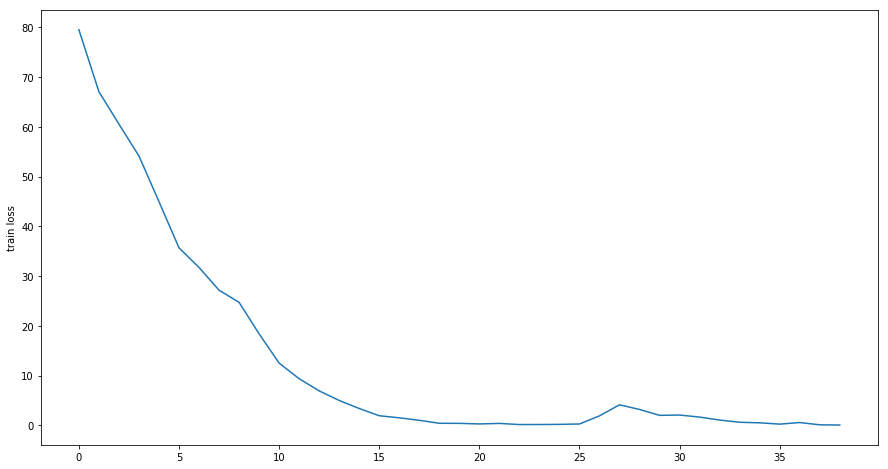

Training EM


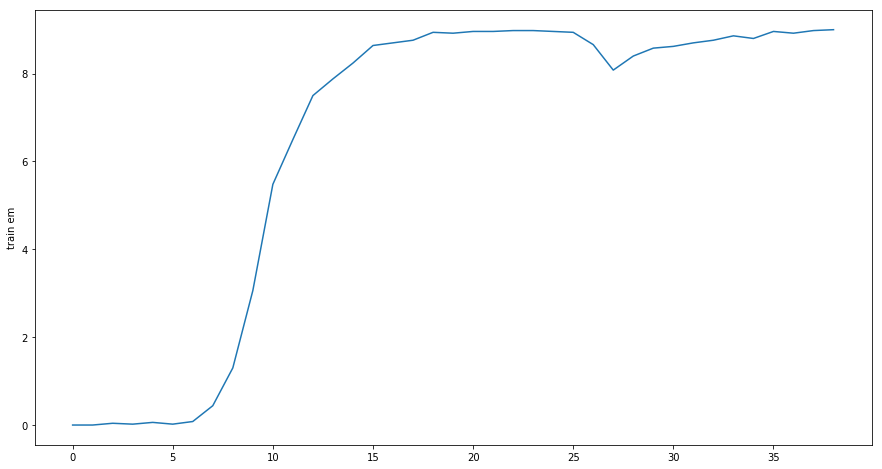

Testing EM


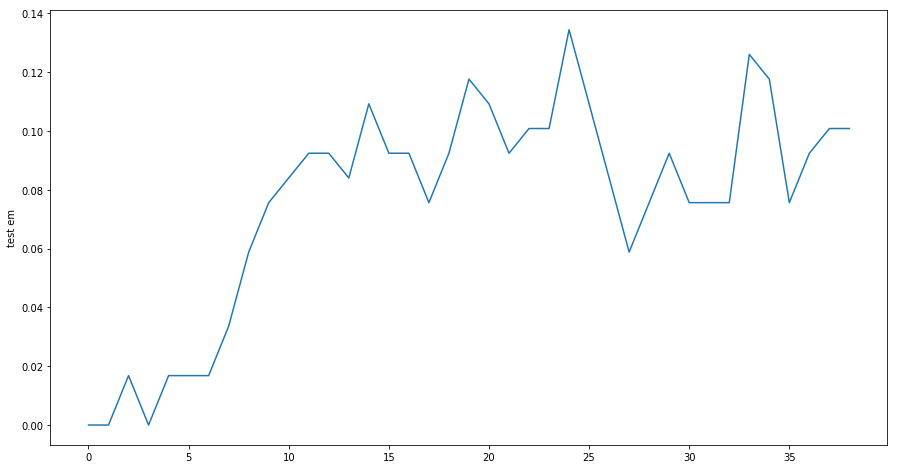

In [17]:
# Visualizations
print("Training Loss")
visualize_loss(op[0], "train loss", _only_epoch=True)

# if len(op[1]) > 0:

print("Training EM")
visualize_loss(op[1], "train em", _only_epoch=True)

print("Testing EM")
visualize_loss(op[3], "test em")


# print(op[1])


In [18]:
# # Testing (temp)
# models = { 'ques_model': ques_model,
#            'para_model': para_model,
#            'mlstm_model':  mlstm_model,
#            'pointer_decoder_model': pointer_decoder_model
#          }
# save_model(loc=macros['save_model_loc'], models=models, epochs=0)

In [19]:
# # Try loading the model
# ques_model = torch.load(os.path.join(macros['save_model_loc'], 'ques_model.torch'))
# print("Ques Model\n", ques_model)

# para_model = torch.load(os.path.join(macros['save_model_loc'], 'para_model.torch'))
# print("Para Model\n", para_model)

# mlstm_model = torch.load(os.path.join(macros['save_model_loc'], 'mlstm_model.torch'))
# print("MLSTM Model\n", mlstm_model)

# pointer_decoder_model = torch.load(os.path.join(macros['save_model_loc'], 'pointer_decoder_model.torch'))
# print("Pointer Decoder model\n", pointer_decoder_model)

# Create dummy data for testing the predict fn
q = np.random.randint(0, len(vectors), (1, 30))
p = np.random.randint(0, len(vectors), (1, 200))
qa = np.repeat(q,macros['batch_size'],axis=0)
pa = np.repeat(p,macros['batch_size'],axis=0)

qb = np.repeat(q,10,axis=0)
pb = np.repeat(p,10,axis=0)

# print(p_repeat.shape)
# print(q_repeat.shape)

ysa, yea, _ = predict(torch.tensor(pa, dtype=torch.long, device=device), 
                                   torch.tensor(qa, dtype=torch.long, device=device),
                                   ques_model=ques_model.eval(),
                                   para_model=para_model.eval(),
                                   mlstm_model=mlstm_model.eval(),
                                   pointer_decoder_model=pointer_decoder_model.eval(),
                                    macros=macros,
                                    debug=macros['debug'])

ysb, yeb, _ = predict(torch.tensor(pb, dtype=torch.long, device=device), 
                                   torch.tensor(qb, dtype=torch.long, device=device),
                                   ques_model=ques_model.eval(),
                                   para_model=para_model.eval(),
                                   mlstm_model=mlstm_model.eval(),
                                   pointer_decoder_model=pointer_decoder_model.eval(),
                                    macros=macros,
                                    debug=macros['debug'])

print(torch.argmax(ysa.squeeze(), dim=1))
print(torch.argmax(ysb.squeeze(), dim=1))

tensor([ 44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,
         44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,
         44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,
         44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,
         44,  44], device='cuda:0')
tensor([ 44,  44,  44,  44,  44,  44,  44,  44,  44,  44], device='cuda:0')


In [20]:
torch.argmax(y_cap_start.squeeze(), dim=1)

NameError: name 'y_cap_start' is not defined